In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, TimeDistributed, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model
from nltk.tokenize import word_tokenize
import unicodedata
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/eng_-french.csv")
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,English words/sentences,French words/sentences
0,The fire was so intense that the firemen could...,L'incendie était tel que les pompiers n'ont pa...
1,I've got a lot of good friends.,J'ai beaucoup de bons amis.
2,Both of them seem suspicious.,Ils semblent tous deux suspects.
3,I hate this apartment.,Je déteste cet appartement.
4,What do you say we go to my house?,Que dites-vous que nous allions chez moi ?


In [5]:
def preprocess_english_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub("[^a-zA-Z\s]", "", text)
    return text

In [6]:
def preprocess_french_text(text):
   # Convert to lowercase
    text = text.lower()

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zÀ-ÿ\s]', '', text)
    # Remove accents
    text = ''.join(char for char in unicodedata.normalize('NFD', text) if unicodedata.category(char) != 'Mn')
    return text

In [7]:
data['French words/sentences'] = data['French words/sentences'].apply(preprocess_french_text)
data['English words/sentences'] = data['English words/sentences'].apply(preprocess_english_text)
data.head()

,English words/sentences,French words/sentences
0,the fire was so intense that the firemen could...,lincendie etait tel que les pompiers nont pas ...
1,ive got a lot of good friends,jai beaucoup de bons amis
2,both of them seem suspicious,ils semblent tous deux suspects
3,i hate this apartment,je deteste cet appartement
4,what do you say we go to my house,que ditesvous que nous allions chez moi


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [9]:
data = data[data['English words/sentences'].apply(lambda x: len(word_tokenize(x))) <= 12].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171969 entries, 0 to 171968
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  171969 non-null  object
 1   French words/sentences   171969 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [10]:
fr=data['French words/sentences']
eng=data['English words/sentences']

In [11]:
fr[2000]

'essayonsen un different'

In [12]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [13]:
def pad(x, max_length):
    return pad_sequences(x, maxlen=max_length, padding='post')

In [14]:
def preprocess(x, y, max_length):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x, max_length)
    preprocess_y = pad(preprocess_y, max_length)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [15]:
max_sequence_length = 10
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(eng, fr, max_sequence_length)

In [16]:
preproc_french_sentences[35000]

array([[   1],
       [  22],
       [1088],
       [  23],
       [4460],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0]], dtype=int32)

In [17]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Max English sentence length: 10
Max French sentence length: 10
English vocabulary size: 13946
French vocabulary size: 30769


In [18]:
def to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = 'pad'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [19]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    learning_rate = 0.003

    # Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [20]:
tmp_x = preproc_english_sentences.reshape((-1, preproc_french_sentences.shape[-2]))

In [21]:
tmp_x.shape

(171969, 10)

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# Train
model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 256)           3570432   
                                                                 
 bidirectional (Bidirection  (None, 10, 512)           789504    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 10, 1024)          525312    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 10, 1024)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 30770)         31539250  
 stributed)                                                      
                                                        

In [23]:
history = model.fit(tmp_x, preproc_french_sentences,
                    batch_size=128,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/30
1075/1075 [==============================] - 179s 159ms/step - loss: 3.2970 - accuracy: 0.5173 - val_loss: 2.5357 - val_accuracy: 0.5782
Epoch 2/30
1075/1075 [==============================] - 167s 155ms/step - loss: 2.4044 - accuracy: 0.5811 - val_loss: 2.2225 - val_accuracy: 0.6027
Epoch 3/30
1075/1075 [==============================] - 171s 159ms/step - loss: 2.0861 - accuracy: 0.6033 - val_loss: 2.0974 - val_accuracy: 0.6137
Epoch 4/30
1075/1075 [==============================] - 167s 155ms/step - loss: 1.8801 - accuracy: 0.6195 - val_loss: 2.0107 - val_accuracy: 0.6237
Epoch 5/30
1075/1075 [==============================] - 171s 159ms/step - loss: 1.7265 - accuracy: 0.6330 - val_loss: 1.9470 - val_accuracy: 0.6283
Epoch 6/30
1075/1075 [==============================] - 171s 159ms/step - loss: 1.6085 - accuracy: 0.6447 - val_loss: 1.9369 - val_accuracy: 0.6319
Epoch 7/30
1075/1075 [==============================] - 167s 155ms/step - loss: 1.5130 - accuracy: 0.6543 - val_

In [ ]:
# Save the model to Google Drive
model.save("/content/drive/My Drive/english_to_french_translation_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


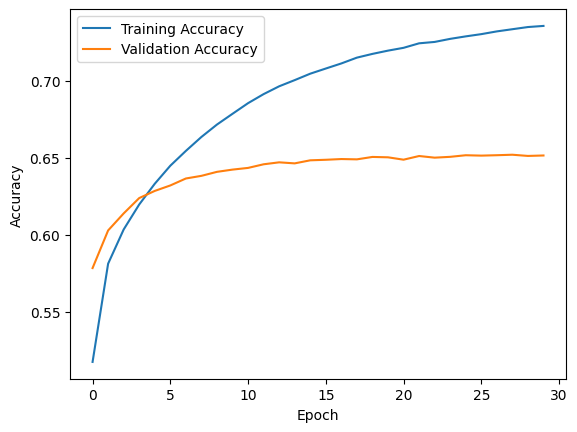

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

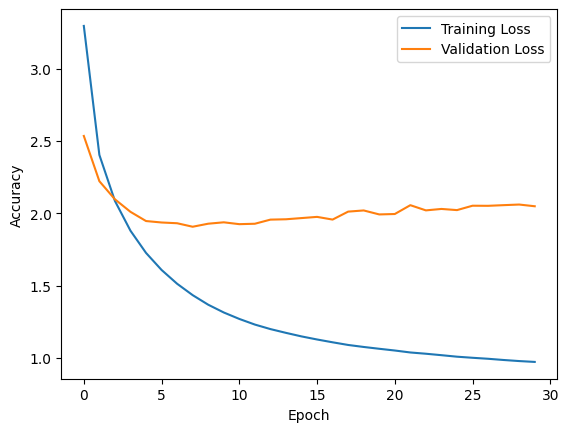

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [30]:
i=1


print("Prediction:")
print(to_text(model.predict(tmp_x[[i]])[0], french_tokenizer))
print("\nCorrect Translation:")
print(fr[i])

print("\nOriginal text:")
print(eng[i])

Prediction:
1/1 [==============================] - 0s 72ms/step
ils semblent toutes deux mefiantes pad pad pad pad pad

Correct Translation:
ils semblent tous deux suspects

Original text:
both of them seem suspicious


In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Updated pad function
def pad_sequence(sequence, max_length):
    return pad_sequences(sequence, maxlen=5, padding='post')

# Function to preprocess user input and perform translation
def translate_sentence(input_sentence, english_tokenizer, french_tokenizer, model):
    # Tokenize and pad the user input
    input_sequence = english_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequence(input_sequence, max_english_sequence_length)

    # Get the model's prediction
    predicted = model.predict(input_sequence)

    # Convert model output to text
    translated_sentence = to_text(predicted[0], french_tokenizer)

    return translated_sentence

# Example usage:
user_input = input("Enter an English sentence: ")

# Call the translation function
translation = translate_sentence(user_input, english_tokenizer, french_tokenizer, model)
print("Translated French sentence:", translation)


Enter an English sentence: he is my brother
1/1 [==============================] - 0s 18ms/step
Translated French sentence: cest mon frere frere pad


In [ ]:
i

200